# Progress report 4 notebook

## Overview
This notebook loads and parses a sample of the XML data used in the project. A general report that includes more information about the project is available in the [project report](../docs/progress_report.md).

This notebook continues progress reports 1–3, integrating improvements, corrections, and new functionality. This is the *existing* option for report 3, renamed for easy access to and comparison of the three stages. Major changes from earlier approach (see [Progress report 3](progress_report_3.ipynb) for details) are:

1. Decomposition is into C(C)/V, rather than syllables
2. Rhymes is identified by segments, rather than distinctive features

Phonetic distinctive features will return for evaluating and analyzing rhyming lines, even if no longer for identifying them.

## Sample data

The sample dataset consists of multiple stanzas from a long poem. An artificial one-stanza extract looks like the following:

```xml
<poem opid="Eo.1">
    <stanza stanzaNo="001">
        <line lineNo="001">"Мой дядя самых честных пр<stress>а</stress>вил,</line>
        <line lineNo="002">Когда не в шутку занем<stress>о</stress>г,</line>
        <line lineNo="003">Он уважать себя заст<stress>а</stress>вил</line>
        <line lineNo="004">И лучше выдумать не м<stress>о</stress>г.</line>
        <line lineNo="005">Его пример другим на<stress>у</stress>ка;</line>
        <line lineNo="006">Но, боже мой, какая ск<stress>у</stress>ка</line>
        <line lineNo="007">С больным сидеть и день и н<stress>о</stress>чь,</line>
        <line lineNo="008">Не отходя ни шагу пр<stress>о</stress>чь!</line>
        <line lineNo="009">Какое низкое ков<stress>а</stress>рство</line>
        <line lineNo="010">Полу-живого забавл<stress>я</stress>ть,</line>
        <line lineNo="011">Ему подушки поправл<stress>я</stress>ть,</line>
        <line lineNo="012">Печально подносить лек<stress>а</stress>рство,</line>
        <line lineNo="013">Вздыхать и думать про себ<stress>я</stress>:</line>
        <line lineNo="014">Когда же чорт возьмет теб<stress>я</stress>!"</line>
    </stanza>
</poem>   
```

## Reload libraries each time, since we’re tinkering with them

In [1]:
%load_ext autoreload
%autoreload 2

## Load libraries

In [2]:
from xml.dom import pulldom  # parse input XML
from xml.dom.minidom import Document  # construct output XML
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
from cyr2phon import cyr2phon  # custom package
pd.set_option('display.max_colwidth', -1) # show all text in cell, without truncation; default is 50

## Class and variables for parsing input XML

In [3]:
class Stack(list):  # keep track of open nodes while constructing XML output
    def push(self, item):
        self.append(item)

    def peek(self):  
        return self[-1]


open_elements = Stack()
WS_RE = re.compile(r'\s+')  # normalize white space in output

## Function to parse the XML

Returns a list of lists, with stanza number, line number, and `<line>` element for each line. We use the light-weight *xml.dom.pulldom* library to parse the input XML and *xml.dom.minidom* to construct the lines as simplified XML, removing elements we don’t care about, such as `<latin>` and `<italic>`, before serializing them to the output. (We actually do care about `<latin>`, but we are ignoring it temporarily, and we’ll return to it at a later stage in the project.)

In [4]:
def process(input_xml):
    poemId = ""
    stanzaNo = 0
    lineNo = 0
    inline = 0  # flag to control behavior inside and outside lines
    result = []  # array of arrays, one per line, with stanzaNo, lineNo, and serialized XML
    doc = pulldom.parse(input_xml)
    for event, node in doc:
        if event == pulldom.START_ELEMENT and node.localName == 'poem':
            poemId = node.getAttribute("opid")
        elif event == pulldom.START_ELEMENT and node.localName == 'stanza':
            stanzaNo = node.getAttribute("stanzaNo")
        elif event == pulldom.START_ELEMENT and node.localName == 'line':
            d = Document()  # each line is an output XML document
            open_elements.push(d)  # document node
            lineNo = node.getAttribute("lineNo")
            inline = 1  # we’re inside a line
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'line':
            inline = 0  # when we finish our work here, we’ll no longer be inside a line
            open_elements.pop()  # line is finished
            # serialize XML, strip declaration, rewrite &quot; entity as character
            result.append([poemId, int(stanzaNo), int(lineNo),
                WS_RE.sub(" " ,
                open_elements.pop().toxml().replace('<?xml version="1.0" ?>', '').replace('&quot;', '"'))])
        elif event == pulldom.START_ELEMENT and node.localName == 'stress':
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'stress':
            open_elements.pop()  # stress element is finished
        elif event == pulldom.CHARACTERS and inline:  # keep text only inside lines
            t = d.createTextNode(node.data)
            open_elements.peek().appendChild(t)
    return result

## Parse the XML into an array of arrays

In [5]:
# Uncomment one of the two lines below depending on whether you have access to the full data
# data = "data_samples/eo1.xml" # public sample data
data = "../data/eo-all.xml" # private full data

with open(data) as f:
    all_lines = process(f)
all_lines[:5]  # take a look

[['Eo.1',
  1,
  1,
  '<line lineNo="001">"Мой дядя самых честных пр<stress>а</stress>вил,</line>'],
 ['Eo.1',
  1,
  2,
  '<line lineNo="002">Когда не в шутку занем<stress>о</stress>г,</line>'],
 ['Eo.1',
  1,
  3,
  '<line lineNo="003">Он уважать себя заст<stress>а</stress>вил</line>'],
 ['Eo.1',
  1,
  4,
  '<line lineNo="004">И лучше выдумать не м<stress>о</stress>г.</line>'],
 ['Eo.1',
  1,
  5,
  '<line lineNo="005">Его пример другим на<stress>у</stress>ка;</line>']]

## General descriptive information: the wrong way

Here is the wrong way to get general information; it assumes that all stanzas contain 14 lines. There are four that don’t:

1. 3.3 has 8 lines
1. 4.37 has 13 lines
1. 8.2 has 4 lines
1. 8.25 has 8 lines

In [6]:
line_count = len(all_lines)
print ('There are ' + str(line_count / 14) + ' 14-line stanzas in this sample, with a total of ' + 
       str(line_count) + ' lines.\nSince we know that the poem is fully rhymed, there are ' + 
       str(line_count / 2) + ' rhyme pairs in the sample.')

There are 364.35714285714283 14-line stanzas in this sample, with a total of 5101 lines.
Since we know that the poem is fully rhymed, there are 2550.5 rhyme pairs in the sample.


That’s all wrong. We’ll fix it after we write the data into a dataframe.

## Write the data into a dataframe

In [7]:
df = pd.DataFrame(all_lines, columns=["PoemId", "StanzaNo", "LineNo", "Text"])
df.head(5)

,PoemId,StanzaNo,LineNo,Text
0,Eo.1,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>"
1,Eo.1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>"
2,Eo.1,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>"
3,Eo.1,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>"
4,Eo.1,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>"


## Descriptive information about the cantos, stanzas, and lines

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5101 entries, 0 to 5100
Data columns (total 4 columns):
PoemId      5101 non-null object
StanzaNo    5101 non-null int64
LineNo      5101 non-null int64
Text        5101 non-null object
dtypes: int64(2), object(2)
memory usage: 159.5+ KB


In [9]:
cantos = df.groupby("PoemId").count()
print(cantos["StanzaNo"]) # line count by canto

PoemId
Eo.1    756
Eo.2    560
Eo.3    568
Eo.4    601
Eo.5    588
Eo.6    602
Eo.7    728
Eo.8    698
Name: StanzaNo, dtype: int64


### Stanzas with fewer than 14 lines (or, in theory, more)

In [10]:
df.groupby(["PoemId", "StanzaNo"]).filter(lambda x: x["LineNo"].count() != 14).groupby(["PoemId", "StanzaNo"]).count()["LineNo"]

PoemId  StanzaNo
Eo.3    3           8 
Eo.4    37          13
Eo.8    2           4 
        25          8 
Name: LineNo, dtype: int64

### Lines without stress

In [11]:
df[df["Text"].str.contains("stress") == False]

,PoemId,StanzaNo,LineNo,Text
2302,Eo.4,37,13,"<line lineNo=""013"">И одевался...</line>"


### Lines with non-Cyrillic stress

Rhyme reports about these lines are likely to be wrong. Do something about it eventually.

In [12]:
df[df["Text"].str.contains(r'<stress>[^а-яА-Я]</stress>')][["PoemId", "StanzaNo", "LineNo", "Text"]]

,PoemId,StanzaNo,LineNo,Text
75,Eo.1,6,6,"<line lineNo=""006"">В конце письма поставить v<stress>a</stress>le, </line>"
192,Eo.1,17,11,"<line lineNo=""011"">Готов охлопать entrech<stress>a</stress>t, </line>"
1340,Eo.3,2,11,"<line lineNo=""011"">И слез, и рифм et ceter<stress>a</stress> ?:</line>"
2187,Eo.4,28,10,"<line lineNo=""010""> Qu'écrirez-vous sur ces tabl<stress>e</stress>ttes; </line>"
2188,Eo.4,28,11,"<line lineNo=""011"">И подпись: t. à v. Ann<stress>e</stress>tte; </line>"
2368,Eo.4,43,10,"<line lineNo=""010"">Читай: вот Прадт, вот W. Sc<stress>o</stress>tt. </line>"
2856,Eo.5,27,8,"<line lineNo=""008""> Réveillez vous, belle endorm<stress>i</stress>e. </line>"
2861,Eo.5,27,13,"<line lineNo=""013"">И смело вместо belle Nin<stress>a</stress> </line>"
2862,Eo.5,27,14,"<line lineNo=""014"">Поставил belle Tatian<stress>a</stress>. </line>"
3410,Eo.6,27,2,"<line lineNo=""002"">""Вот он: мой друг, monsieur Guill<stress>o</stress>t. </line>"


## Transliterate all lines and save in new column

1. Because only the last stress in the line is marked, the phonetic representation of all words except the last is incorrect. That doesn’t matter for the analysis of end rhyme.
1. Words in foreign languages are not being treated specially, and are therefore usually phonetically incorrect. That *does* matter for the analysis of end rhyme. Deal with it later, first by excluding those lines (revise the XML parsing to record that information), and eventually by phoneticizing them correctly.
1. The `transliterate()` function is part of the [custom *cyr2phon* package](cyr2phon/cyr2phon.py).

In [13]:
trans_vec = np.vectorize(cyr2phon.transliterate)
df["Phonetic"] = trans_vec(df["Text"])
df.head()  # take a look

,PoemId,StanzaNo,LineNo,Text,Phonetic
0,Eo.1,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>",maJ DiDi samix Čistnix prAVil
1,Eo.1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>",kagda Nifšutku zaNimOk
2,Eo.1,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>",an uvažaT SiBi zastAVil
3,Eo.1,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>",iluČši vidumaT NimOk
4,Eo.1,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>",Jiva pRiMir druGim naUka


## Write the rhyme word into a new column

In [14]:
df["RhymeWord"] = df["Phonetic"].str.split().str[-1] # clitics have already been joined
df.head()  # take a look

,PoemId,StanzaNo,LineNo,Text,Phonetic,RhymeWord
0,Eo.1,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>",maJ DiDi samix Čistnix prAVil,prAVil
1,Eo.1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>",kagda Nifšutku zaNimOk,zaNimOk
2,Eo.1,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>",an uvažaT SiBi zastAVil,zastAVil
3,Eo.1,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>",iluČši vidumaT NimOk,NimOk
4,Eo.1,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>",Jiva pRiMir druGim naUka,naUka


## Identify rhyme zone and write into new column

The *rhyme zone* is the portion of the line that participates in line end-rhyme. According to Russian rhyming conventions, the rhyme zone typically begins with the last stressed vowel of the line and continues until the end of the line. The one exception is that open masculine rhyme (that is, rhyme involving stress on a final syllable that ends in a vowel, e.g., **себя́** *[SiBA]*) also requires a *supporting consonant*, that is, it also requires that the consonants *before the stressed vowels* (not otherwise considered part of the rhyme zone* also agree. For example:

* _see_ and _tree_ do not rhyme in Russian because this open (ends in a vowel sound) masculine (stress on the final syllable) rhyme does not have a supporting consonant (consonants before the stressed vowels do not agree).
* *seat* and *treat* do rhyme in Russian because closed (ends in a consonant sound) masculine (stress on the final syllable) rhyme does not require a supporting consonant, so the lack of phonetic correspondence between the consonants before the stressed vowels does not matter.

Russian rhyme may also be *enriched* by phonetic agreement or similarity outside the rhyme zone. For example, *stop* and *strop* constitute a perfect rhyme because the *op* sounds match. Nonetheless, the match of *st* before the rhyme zone enhances, or enriches, the rhyme. The present study ignores enrichment and concentrates only on the core rhyme components, but enrichment will be incorporated into the analysis at a later stage.

With that said, this first pass at identifying the rhyme zone removes the pretonic segments, but not the final consonant of a pretonic onset where a supporting consonant is not needed. More cleaning to follow!

In [15]:
rhymezonepat = re.compile(r'(.?[AEIOU]$)|([AEIOU].*$)')
def remove_pretonic_segments(s: str) -> str: # removes segments in place
    try:
        return rhymezonepat.search(s).group(0)
    except: # modify this to raise a real error, instead of just reporting
        print(s)
df["RhymeZone"] = df["RhymeWord"].apply(remove_pretonic_segments)
df.head(14)

iaDivalSi
têti-à-tÊti


,PoemId,StanzaNo,LineNo,Text,Phonetic,RhymeWord,RhymeZone
0,Eo.1,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>",maJ DiDi samix Čistnix prAVil,prAVil,AVil
1,Eo.1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>",kagda Nifšutku zaNimOk,zaNimOk,Ok
2,Eo.1,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>",an uvažaT SiBi zastAVil,zastAVil,AVil
3,Eo.1,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>",iluČši vidumaT NimOk,NimOk,Ok
4,Eo.1,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>",Jiva pRiMir druGim naUka,naUka,Uka
5,Eo.1,1,6,"<line lineNo=""006"">Но, боже мой, какая ск<stress>у</stress>ка</line>",nabaži maJ kakaJi skUka,skUka,Uka
6,Eo.1,1,7,"<line lineNo=""007"">С больным сидеть и день и н<stress>о</stress>чь,</line>",zbaLnim SiDiT iDiN inOČ,inOČ,OČ
7,Eo.1,1,8,"<line lineNo=""008"">Не отходя ни шагу пр<stress>о</stress>чь!</line>",NiatxaDi Nišagu prOČ,prOČ,OČ
8,Eo.1,1,9,"<line lineNo=""009"">Какое низкое ков<stress>а</stress>рство</line>",kakaJi NiskaJi kavArstva,kavArstva,Arstva
9,Eo.1,1,10,"<line lineNo=""010"">Полу-живого забавл<stress>я</stress>ть,</line>",palu-živava zabavLAT,zabavLAT,AT


## Tokenize rhyme zone into C(C) and V

We may have some null values in the rhyme zone for incomplete lines that have no final stressed syllable (*EO* 37: 13) and foreign words that we may not be handling properly (*EO* 23:2). Check for those:

In [16]:
df[df["RhymeZone"].isnull()]

,PoemId,StanzaNo,LineNo,Text,Phonetic,RhymeWord,RhymeZone
2302,Eo.4,37,13,"<line lineNo=""013"">И одевался...</line>",iaDivalSi,iaDivalSi,None
4702,Eo.8,23,2,"<line lineNo=""002"">Сей неприятный tête-à-t<stress>ê</stress>te; </line>",SiJ NipRiJitniJ têti-à-tÊti,têti-à-tÊti,None


Filter them out provisionally by writing in a placeholder value:

In [17]:
df.loc[df["RhymeZone"].isnull(), "RhymeZone"] = "Abcde"
df[df["RhymeZone"] == "Abcde"]

,PoemId,StanzaNo,LineNo,Text,Phonetic,RhymeWord,RhymeZone
2302,Eo.4,37,13,"<line lineNo=""013"">И одевался...</line>",iaDivalSi,iaDivalSi,Abcde
4702,Eo.8,23,2,"<line lineNo=""002"">Сей неприятный tête-à-t<stress>ê</stress>te; </line>",SiJ NipRiJitniJ têti-à-tÊti,têti-à-tÊti,Abcde


In [18]:
df["tokenized"] = [x[0] for x in df["RhymeZone"].str.
                   findall(r"(.?)([AEIOU])([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)")]
i = 0
while pd.np.count_nonzero([item[i] for item in df["tokenized"]]) > 0:
    # print([item[i] for item in df["tokenized"]]) # diagnostic
    df["token" + str(i)] = [item[i] for item in df["tokenized"]]
    i += 1
tokenheaders = df.filter(regex="^token\d").columns
# tokenheaders = list([item for item in df.columns if re.match(r'token\d', item)])
df[tokenheaders] = df[tokenheaders].replace(r'^$', "missing", regex=True) # replace empty strings with specific value; inplace doesn't work (?)
df.filter(regex=r"StanzaNo|LineNo|RhymeWord|Text|^token\d").head() # columns we care about

,StanzaNo,LineNo,Text,RhymeWord,token0,token1,token2,token3,token4,token5
0,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>",prAVil,missing,A,V,i,l,missing
1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>",zaNimOk,missing,O,k,missing,missing,missing
2,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>",zastAVil,missing,A,V,i,l,missing
3,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>",NimOk,missing,O,k,missing,missing,missing
4,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>",naUka,missing,U,k,a,missing,missing


## One-hot encode token columns

`df = pd.get_dummies(df, columns=df.filter(regex="^token\d").columns, drop_first=True)` will replace the original categorical values with binary ones. The approach below keeps both and avoids duplication.

In [19]:
# Danger: don’t rerun this; it will one-hot encode the output of the previous one-hot encoding!
dummy = pd.get_dummies(df, columns=df.filter(regex="^token\d").columns, drop_first=True)

In [20]:
df = df.merge(dummy, on=["PoemId", "StanzaNo", "LineNo", "Text", "Phonetic", "RhymeWord", "RhymeZone", "tokenized"])

In [21]:
# Multindex on PoemId (canto), StanzaNo, and LineNo; stanza will be rhyme domain
df.set_index(["PoemId", "StanzaNo", "LineNo"], inplace=True)
df.head()

Text  \
PoemId StanzaNo LineNo                                                                               
Eo.1   1        1       <line lineNo="001">"Мой дядя самых честных пр<stress>а</stress>вил,</line>   
                2       <line lineNo="002">Когда не в шутку занем<stress>о</stress>г,</line>         
                3       <line lineNo="003">Он уважать себя заст<stress>а</stress>вил</line>          
                4       <line lineNo="004">И лучше выдумать не м<stress>о</stress>г.</line>          
                5       <line lineNo="005">Его пример другим на<stress>у</stress>ка;</line>          

                                             Phonetic RhymeWord RhymeZone  \
PoemId StanzaNo LineNo                                                      
Eo.1   1        1       maJ DiDi samix Čistnix prAVil  prAVil    AVil       
                2       kagda Nifšutku zaNimOk         zaNimOk   Ok         
                3       an uvažaT SiBi zastAVil        zastAVil  AVil       
                4       iluČši vidumaT NimOk           NimOk     Ok         
                5       Jiva pRiMir druGim naUka       naUka     Uka        

                                                       tokenized   token0  \
PoemId StanzaNo LineNo                                                      
Eo.1   1        1       (, A, V, i, l, , , , , , , , , , , , , )  missing   
                2       (, O, k, , , , , , , , , , , , , , , )    missing   
                3       (, A, V, i, l, , , , , , , , , , , , , )  missing   
                4       (, O, k, , , , , , , , , , , , , , , )    missing   
                5       (, U, k, a, , , , , , , , , , , , , , )   missing   

                       token1 token2   token3   token4  ... token4_k  \
PoemId StanzaNo LineNo                                  ...            
Eo.1   1        1       A      V      i        l        ...  0         
                2       O      k      missing  missing  ...  0         
                3       A      V      i        l        ...  0         
                4       O      k      missing  missing  ...  0         
                5       U      k      a        missing  ...  0         

                        token4_l  token4_m  token4_missing  token4_n  \
PoemId StanzaNo LineNo                                                 
Eo.1   1        1       1         0         0               0          
                2       0         0         1               0          
                3       1         0         0               0          
                4       0         0         1               0          
                5       0         0         1               0          

                        token4_s  token4_t  token4_x  token4_š  token5_missing  
PoemId StanzaNo LineNo                                                          
Eo.1   1        1       0         0         0         0         1               
                2       0         0         0         0         1               
                3       0         0         0         0         1               
                4       0         0         0         0         1               
                5       0         0         0         0         1               

[5 rows x 163 columns]

## Is rhyme identification a supervised or unsupervised question?

### Unsupervised

#### Overview

An *unsupervised* approach to rhyme identification regards it as a *clustering* problem. Within the domain to be searched (e.g., stanza, sliding window of four lines):

1. Form clusters hierarchically according to shortest distance. 
1. Determine where the clustering makes a transition from informational to artifactual.

#### Observations

* There is no separation of training and testing sets and no predefined rhymed or non-rhymed assessments for line pairs. 
* The method does not require pairwise line comparison—except insofar as that is implicit in the black box that performs the clustering.
* The method naturally recognizes degree or confidence of rhyme identification: except as mediated by interlinear distamce, it should cluster perfect rhyme first, and then increasingly approximate rhyme, a hierarchy that is consistent with human intuition.

#### Issues

* **Parameters.** The *linkage* (clustering method: simple, complete, Ward’s, centroid) and *affinity* (distance measure: Euclidean, Manhattan) are to be determined (perhaps with GridSearch?). 
* **Scaling.** One-hot encoded segment information is binary and proximity (represented by line number) is ordinal. Should they be normalized? On the one hand, if they aren’t, distance might dwarf the binary features. On the other hand, does distance have an absolute quality? For example, being within 10% of the line count in a ten-line stanza is adjacent, and therefore meaningful. In a hundred-line non-stanzaic poem, though, it is distant and of dubious significance.
* **Weighting.** At least once scaling has been applied, all features are weighted similarly. Should they be? Can the system advise us about preferential weighting?
* **Feedback.** It is unclear how the results of a clustering analysis can be translated into eventual weighting information. Since we know the correct outcome, we can identify correct and incorrect results. Can we feed that back into weighting adjustments?
* **Phonetic distinctive features.** We don’t yet see a way to perform comparison at the level of phonetic distinctive features as long as consonant clusters of different lengths may be aligned. But we could decompose vowels, since those are always singletons. Is it useful (or even practical) to decompose some segments and not others? We could test whether features matter by looking for statistically significant differences among the three unstressed vowels, *[i, u, a]*.
* **Enrichment.** At the moment we ignore pretonic information, but it should be incorporated,  even if only at a lower weight. For the moment the pretonic consonant is relevant only for open masculine rhyme, and in that case it is always a singleton, and therefore amenable to feature decomposition (see immediately above). Once we incorporate enrichment, though, does the pretonic cluster become more important than the pretonic consonant?

## Exploratory dendrograms

Generate dendrograms for first 10 stanzas (1–11, since 9 is missing).

In addition to the one-hot-encoded C(C) ~ V information, line number is treated as a feature, under the assumption that rhyme involves not only phonetic similarity, but also proximity. Earlier trials with raw line numbers distorted the output, so the values are normalized (scaled), by trial and error, to range from 0–2. Initial linkage method was Ward; for discussion of options see <https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering> and <https://stats.stackexchange.com/questions/63546/comparing-hierarchical-clustering-dendrograms-obtained-by-different-distances/63549#63549>. 

                                                   Text  RhymeWord
PoemId StanzaNo LineNo                                            
Eo.1   1        1       "Мой дядя самых честных правил,  prAVil   
                2       Когда не в шутку занемог,        zaNimOk  
                3       Он уважать себя заставил         zastAVil 
                4       И лучше выдумать не мог.         NimOk    
                5       Его пример другим наука;         naUka    
                6       Но, боже мой, какая скука        skUka    
                7       С больным сидеть и день и ночь,  inOČ     
                8       Не отходя ни шагу прочь!         prOČ     
                9       Какое низкое коварство           kavArstva
                10      Полу-живого забавлять,           zabavLAT 
                11      Ему подушки поправлять,          papravLAT
                12      Печально подносить лекарство,    LikArstva
                13      Вздыхать и думать про себя:      praSi

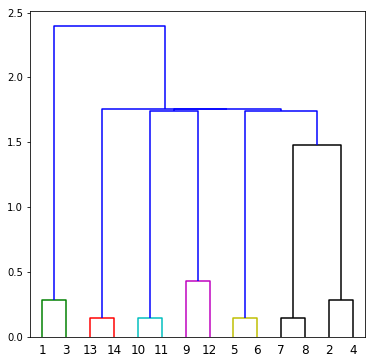

                                                 Text   RhymeWord
PoemId StanzaNo LineNo                                           
Eo.1   2        1       Так думал молодой повеса,      paVEsa    
                2       Летя в пыли на почтовых,       napaČtavIx
                3       Всевышней волею Зевеса         ZiVEsa    
                4       Наследник всех своих родных.—  radnIx    
                5       Друзья Людмилы и Руслана!      iruslAna  
                6       С героем моего романа          ramAna    
                7       Без предисловий, сей же час    ČAs       
                8       Позвольте познакомить вас:     vAs       
                9       Онегин, добрый мой приятель,   pRiJATiL  
                10      Родился на брегах Невы,        NivI      
                11      Где может быть родились вы,    vI        
                12      Или блистали, мой читатель;    ČitATiL   
                13      Там некогда гулял и я:         iJA       
          

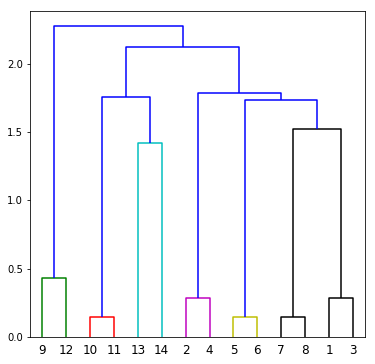

                                                     Text           RhymeWord
PoemId StanzaNo LineNo                                                       
Eo.1   3        1       Служив отлично-благородно,         aTLiČna-blagarOdna
                2       Долгами жил его отец,              aTEts             
                3       Давал три бала ежегодно            JižigOdna         
                4       И промотался наконец.              nakaNEts          
                5       Судьба Евгения хранила:            xraNIla           
                6       Сперва Madame за ним ходила,       xaDIla            
                7       Потом Monsieur ее сменил;          sMiNIl            
                8       Ребенок был резов, но мил.         naMIl             
                9        Monsieur l'Abbé, француз убогой,  ubOgaJ            
                10      Чтоб не измучилось дитя,           DiTA              
                11      Учил его всему шутя,               šuTA 

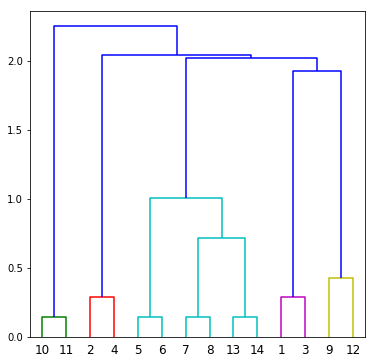

                                                  Text     RhymeWord
PoemId StanzaNo LineNo                                              
Eo.1   4        1       Когда же юности мятежной        MiTEžnaJ    
                2       Пришла Евгению пора,            parA        
                3       Пора надежд и грусти нежной,    NEžnaJ      
                4        Monsieur прогнали со двора.    sadvarA     
                5       Вот мой Онегин на свободе;      nasvabODi   
                6       Острижен по последней моде;     mODi        
                7       Как dandy лондонской одет—      aDEt        
                8       И наконец увидел свет.          sVEt        
                9       Он по-французски совершенно     saViršEna   
                10      Мог изьясняться и писал;        iPisAl      
                11      Легко мазурку танцовал,         tantsavAl   
                12      И кланялся непринужденно;       NipRinužDEna
                13      Чего ж вам

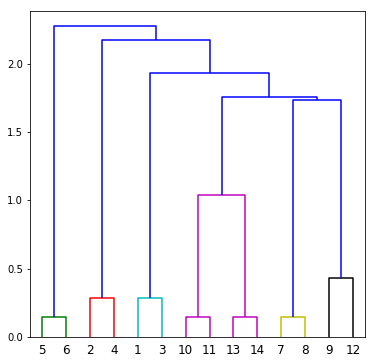

                                                    Text   RhymeWord
PoemId StanzaNo LineNo                                              
Eo.1   5        1       Мы все учились понемногу          paNimnOgu 
                2       Чему-нибудь и как-нибудь,         ikak-NibUT
                3       Так воспитаньем, слава богу,      bOgu      
                4       У нас немудрено блеснуть.         bLisnUT   
                5       Онегин был по мненью многих       mnOGix    
                6       (Судей решительных и строгих)     istrOGix  
                7       Ученый малый, но педант:          naPidAnt  
                8       Имел он счастливый талант         talAnt    
                9       Без принужденья в разговоре       vrazgavORi
                10      Коснуться до всего слегка,        SLikA     
                11      С ученым видом знатока            znatakA   
                12      Хранить молчанье в важном споре,  spORi     
                13      И возбужда

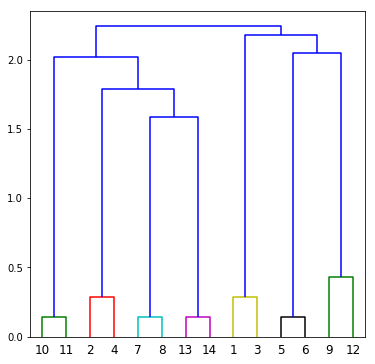

                                                   Text   RhymeWord
PoemId StanzaNo LineNo                                             
Eo.1   6        1       Латынь из моды вышла ныне:       nINi      
                2       Так, если правду вам сказать,    skazAT    
                3       Он знал довольно по-латыне,      pa-latINi 
                4       Чтоб эпиграфы разбирать,         razBirAT  
                5       Потолковать об Ювенале,          aBuVinALi 
                6       В конце письма поставить vale,   vAli      
                7       Да помнил, хоть не без греха,    NiBizgRixA
                8       Из Энеиды два стиха.             STixA     
                9       Он рыться не имел охоты          axOti     
                10      В хронологической пыли           piLI      
                11      Бытописания земли:               ZimLI     
                12      Но дней минувших анекдоты        aNigdOti  
                13      От Ромула до наших дней 

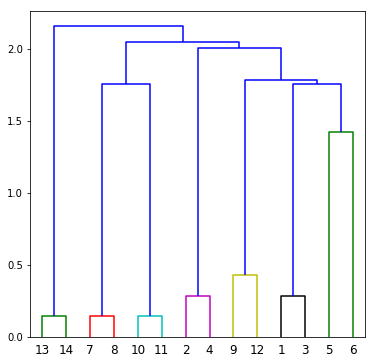

                                                Text  RhymeWord
PoemId StanzaNo LineNo                                         
Eo.1   7        1       Высокой страсти не имея       NiJiMEJi 
                2       Для звуков жизни не щадить,   NiQaDIT  
                3       Не мог он ямба от хорея,      atxaREJi 
                4       Как мы ни бились, отличить.   aTLiČIT  
                5       Бранил Гомера, Феокрита;      FiakRIta 
                6       За то читал Адама Смита,      sMIta    
                7       И был глубокой эконом,        ikanOm   
                8       То есть, умел судить о том,   atOm     
                9       Как государство богатеет,     bagaTEJit
                10      И чем живет, и почему         ipaČimU  
                11      Не нужно золота ему,          JimU     
                12      Когда простой продукт имеет.  iMEJit   
                13      Отец понять его не мог        NimOk    
                14      И земли отдавал 

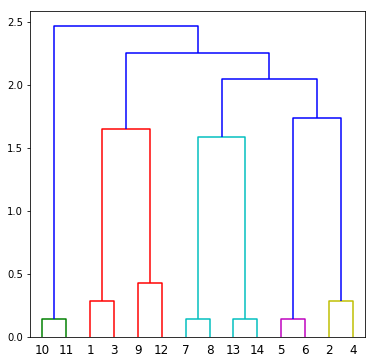

                                                   Text  RhymeWord
PoemId StanzaNo LineNo                                            
Eo.1   8        1       Всего, что знал еще Евгений,     JivGENiJ 
                2       Пересказать мне недосуг;         NidasUk  
                3       Но в чем он истинный был гений,  GENiJ    
                4       Что знал он тверже всех наук,    naUk     
                5       Что было для него измлада        izmlAda  
                6       И труд и мука и отрада,          iatrAda  
                7       Что занимало целый день          DEN      
                8       Его тоскующую лень,—             LEN      
                9       Была наука страсти нежной,       NEžnaJ   
                10      Которую воспел Назон,            nazOn    
                11      За что страдальцем кончил он     On       
                12      Свой век блестящий и мятежный    iMiTEžniJ
                13      В Молдавии, в глуши степей,      STiPE

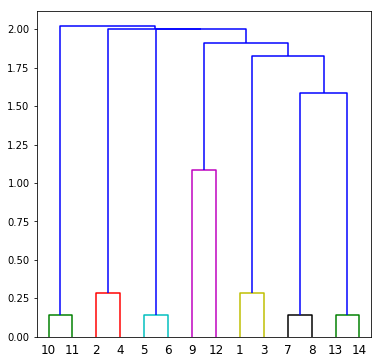

                                                     Text      RhymeWord
PoemId StanzaNo LineNo                                                  
Eo.1   10       1       Как рано мог он лицемерить,        LitsiMERiT   
                2       Таить надежду, ревновать,          RivnavAT     
                3       Разуверять, заставить верить,      VERiT        
                4       Казаться мрачным, изнывать,        iznivAT      
                5       Являться гордым и послушным,       ipaslUšnim   
                6       Внимательным, иль равнодушным!     iLravnadUšnim
                7       Как томно был он молчалив,         malČiLIf     
                8       Как пламенно красноречив,          krasnaRiČIf  
                9       В сердечных письмах как небрежен!  NibREžin     
                10      Одним дыша, одно любя,             LuBA         
                11      Как он умел забыть себя!           SiBA         
                12      Как взор его был быстр и не

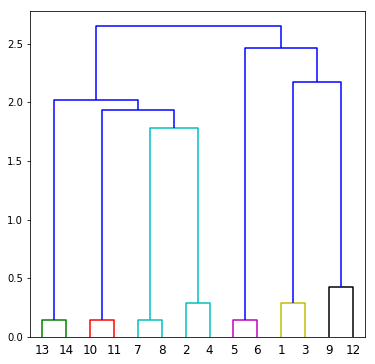

                                                  Text      RhymeWord
PoemId StanzaNo LineNo                                               
Eo.1   11       1       Как он умел казаться новым,     nOvim        
                2       Шутя невинность изумлять,       izumLAT      
                3       Пугать отчаяньем готовым,       gatOvim      
                4       Приятной лестью забавлять,      zabavLAT     
                5       Ловить минуту умиленья,         uMiLENJi     
                6       Невинных лет предубежденья      pRiduBižDENJi
                7       Умом и страстью побеждать,      paBiždAT     
                8       Невольной ласки ожидать,        ažidAT       
                9       Молить и требовать признанья,   pRiznANJi    
                10      Подслушать сердца первый звук,  zvUk         
                11      Преследовать любовь, и вдруг    ivdrUk       
                12      Добиться тайного свиданья...    sVidANJi     
                13  

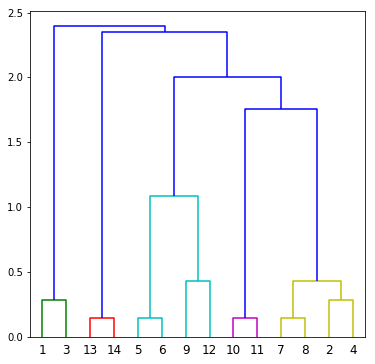

                                                Text  RhymeWord
PoemId StanzaNo LineNo                                         
Eo.1   12       1       Как рано мог уж он тревожить  tRivOžiT 
                2       Сердца кокеток записных!      zaPisnIx 
                3       Когда ж хотелось уничтожить   uNiČtOžiT
                4       Ему соперников своих,         svaJIx   
                5       Как он язвительно злословил!  zlaslOVil
                6       Какие сети им готовил!        gatOVil  
                7       Но вы, блаженные мужья,       mužJA    
                8       С ним оставались вы друзья:   druZJA   
                9       Его ласкал супруг лукавый,    lukAviJ  
                10      Фобласа давний ученик,        uČiNIk   
                11      И недоверчивый старик,        staRIk   
                12      И рогоносец величавый,        ViLiČAviJ
                13      Всегда довольный сам собой,   sabOJ    
                14      Своим обедом и ж

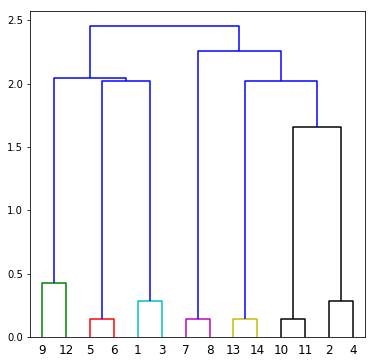

In [25]:
stanzas = df.groupby(level=[0,1])
i = 0
for id, lines in stanzas:
    if i < 11:
        print(pd.concat([lines["Text"].str.replace(r"<[^>]+?>", ""), lines["RhymeWord"]], axis=1)) # diagnostic
        data = lines.filter(regex=r"^token\d_") # only one-hot features
        labelList = list(range(1, len(lines)+1)) # labels are line numbers within stanza
        data.loc[:,"LineNo"] = [2 * n / len(labelList) for n in labelList] # scale to avoid tyranny of proximity
        linked = linkage(data, )
        plt.figure(figsize=(6, 6))  
        dendrogram(linked, labels=labelList)
        plt.show()
    i += 1